In [1]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Using TensorFlow backend.


In [5]:
df=pd.read_csv("train.csv")

In [6]:
df.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [7]:
df.tail(10)

,date,store,item,sales
912990,2017-12-22,10,50,75
912991,2017-12-23,10,50,70
912992,2017-12-24,10,50,76
912993,2017-12-25,10,50,51
912994,2017-12-26,10,50,41
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [8]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
#represent month in date field as its first day
df['date'] = df['date'].dt.year.astype('str') + '-' + df['date'].dt.month.astype('str') + '-01'
df['date'] = pd.to_datetime(df['date'])

In [10]:
df = df.groupby('date').sales.sum().reset_index()

In [11]:
df.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
date     60 non-null datetime64[ns]
sales    60 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.0 KB


Text(0.5, 1.0, 'Sales over Month')

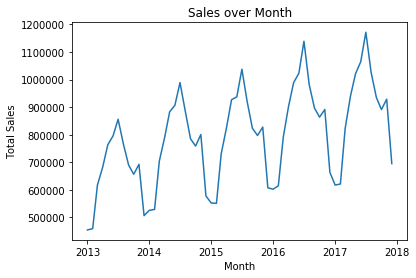

In [13]:
plt.plot(df['date'],df['sales'])
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title("Sales over Month")

In [14]:
df_diff = df.copy()

In [15]:
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)

In [16]:
df_diff.head()

,date,sales,prev_sales
0,2013-01-01,454904,NaN
1,2013-02-01,459417,454904.0
2,2013-03-01,617382,459417.0
3,2013-04-01,682274,617382.0
4,2013-05-01,763242,682274.0


In [17]:
#drop the null values and calculate the difference
df_diff = df_diff.dropna()

In [18]:
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])

In [19]:
df_diff.head()

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0


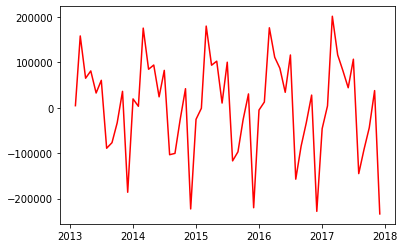

In [20]:
plt.plot(df_diff['date'],df_diff['diff'], color = 'r')

In [21]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [22]:
df_supervised.head()

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


In [23]:
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [24]:

# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.02893426930900389


In [25]:

# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.9795722233296558


In [26]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['sales','date'],axis=1)
df_model

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [27]:
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

In [28]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [29]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [30]:
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [31]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
41/41 [==============================] - 0s 9ms/step - loss: 0.3237
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2874
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2627
Epoch 4/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2412
Epoch 5/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2220
Epoch 6/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2047
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1888
Epoch 8/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1742
Epoch 9/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1609
Epoch 10/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1487
Epoch 11/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1375
Epoch 12/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1272
Epoch 13/100
41/41 [=================

In [32]:
y_pred = model.predict(X_test,batch_size=1)

In [33]:
y_pred

array([[ 0.64984083],
       [-0.6087251 ],
       [-0.40870267],
       [-0.06024304],
       [ 0.18748054],
       [-0.98333585]], dtype=float32)

In [34]:
y_test

array([[ 0.55964922],
       [-0.61313659],
       [-0.36228353],
       [-0.14316792],
       [ 0.23779333],
       [-1.02622661]])

In [35]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
y_pred

array([[[ 0.64984083]],

       [[-0.6087251 ]],

       [[-0.40870267]],

       [[-0.06024304]],

       [[ 0.18748054]],

       [[-0.98333585]]], dtype=float32)

In [36]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ 0.64984083  0.26695937  0.44344626  0.60355899  1.10628178  0.13866328
  -0.10745675 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168]]
[[-0.60872507  0.55964922  0.26695937  0.44344626  0.68877355  1.10628178
   0.13866328 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352]]
[[-0.40870267 -0.61313659  0.55964922  0.26695937  0.52015228  0.68877355
   1.10628178  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458]]
[[-0.06024304 -0.36228353 -0.61313659  0.55964922  0.33428672  0.52015228
   0.68877355  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474]]
[[ 0.18748054 -0.14316792 -0.36228353 -0.61313659  0.64253037  0.33428672
   0.52015228  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439]]
[[-0.98333585  0.23779333 -0.14316792 -0.36228353 -0.59257833  0.64253037
   0.33428672  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392]]


In [37]:
pred_test_set[0]

array([[ 0.64984083,  0.26695937,  0.44344626,  0.60355899,  1.10628178,
         0.13866328, -0.10745675, -1.02635392,  0.24535439, -0.05787474,
        -0.31370458, -0.67437352,  0.68397168]])

In [38]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [39]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [40]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df[-7:].date)
act_sales = list(df[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [41]:
df_result

,date,pred_value
0,2017-07-01,1190754
1,2017-08-01,1027350
2,2017-09-01,925298
3,2017-10-01,908961
4,2017-11-01,918036
5,2017-12-01,704377


In [42]:
df.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [43]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df,df_result,on='date',how='left')

In [44]:
df_sales_pred

,date,sales,pred_value
0,2013-01-01,454904,NaN
1,2013-02-01,459417,NaN
2,2013-03-01,617382,NaN
3,2013-04-01,682274,NaN
4,2013-05-01,763242,NaN
5,2013-06-01,795597,NaN
6,2013-07-01,855922,NaN
7,2013-08-01,766761,NaN
8,2013-09-01,689907,NaN
9,2013-10-01,656587,NaN


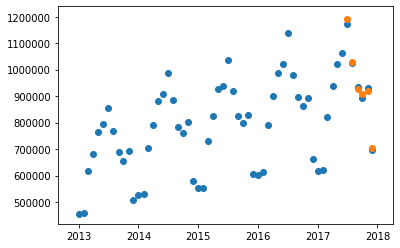

In [45]:
plt.scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['sales'],
    )
plt.scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['pred_value'],
    )
    


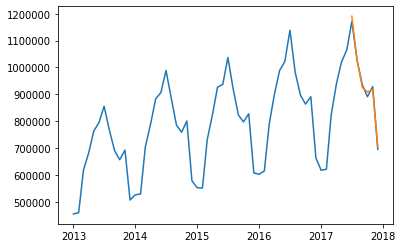

In [46]:
plt.plot(
        df_sales_pred['date'],
        df_sales_pred['sales'],
    )
plt.plot(
        df_sales_pred['date'],
        df_sales_pred['pred_value'],
    )

In [47]:
df_newpredict=pd.read_csv('test.csv')

In [48]:
df_newpredict.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [49]:
df_newpredict['date'] = pd.to_datetime(df_newpredict['date'])
#represent month in date field as its first day
df_newpredict['date'] = df_newpredict['date'].dt.year.astype('str') + '-' + df_newpredict['date'].dt.month.astype('str') + '-01'
df_newpredict['date'] = pd.to_datetime(df_newpredict['date'])


In [50]:
df_newpredict.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-01,1,1
2,2,2018-01-01,1,1
3,3,2018-01-01,1,1
4,4,2018-01-01,1,1


In [51]:
df_final=df_newpredict.drop_duplicates(subset=['date'], keep='last')

In [52]:
df_final=df_final.drop(['id','item','store'],axis=1)

In [53]:
df1=df_final.copy()

In [54]:
df1['diff']=0
df_final['sales']=0

In [55]:
df1.head()

,date,diff
44940,2018-01-01,0
44968,2018-02-01,0
44999,2018-03-01,0


In [56]:
df_final.head()

,date,sales
44940,2018-01-01,0
44968,2018-02-01,0
44999,2018-03-01,0


In [57]:
#create dataframe for transformation from time series to supervised
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df1[field_name] = df1['diff'].shift(inc)
#drop null values
#df1 = df1.dropna().reset_index(drop=True)

In [58]:
df1=df1.fillna(0)

In [59]:
df1=df1.drop(['date'],axis=1)

In [60]:
train_set1=df1.values
train_set1 = train_set1.reshape(train_set1.shape[0], train_set1.shape[1])
train_set1_scaled = scaler.transform(train_set1)

In [61]:
X1_test, y1_test =train_set1_scaled[:, 1:], train_set1_scaled[:, 0:1]
X1_test = X1_test.reshape(X1_test.shape[0], 1, X1_test.shape[1])

In [62]:
z_pred = model.predict(X1_test,batch_size=1)

In [63]:
z_pred

array([[-1.13179654e-01],
       [-1.10467896e-04],
       [ 9.06275064e-02]], dtype=float32)

In [64]:
z_pred = z_pred.reshape(z_pred.shape[0], 1, z_pred.shape[1])
z_pred

array([[[-1.13179654e-01]],

       [[-1.10467896e-04]],

       [[ 9.06275064e-02]]], dtype=float32)

In [65]:
#rebuild test set for inverse transform
pred_test_set1 = []
for index in range(0,len(z_pred)):
    print (np.concatenate([z_pred[index],X1_test[index]],axis=1))
    pred_test_set1.append(np.concatenate([z_pred[index],X1_test[index]],axis=1))
#reshape pred_test_set
pred_test_set1 = np.array(pred_test_set1)
pred_test_set1 = pred_test_set1.reshape(pred_test_set1.shape[0], pred_test_set1.shape[2])
#inverse transform
pred_test_set1_inverted = scaler.inverse_transform(pred_test_set1)
#create dataframe that shows the predicted sales

print(len(pred_test_set1_inverted))
result_list1 = []
sales_dates1 = list(df_final[-3:].date)
act_sales1 = list(df_final[-3:].sales)
for index in range(0,len(pred_test_set1_inverted)):
    result_dict1 = {}
    print(pred_test_set1_inverted[index][0])
    result_dict1['pred_value'] = int(pred_test_set1_inverted[index][0] + act_sales1[index])
    result_dict1['date'] = sales_dates1[index]
    result_list1.append(result_dict1)
df_result1 = pd.DataFrame(result_list1)

[[-0.11317965  0.06228004  0.06228004  0.06228004  0.11873054  0.11873054
   0.11873054  0.10711809  0.10711809  0.10711809  0.10711809  0.10711809
   0.10711809]]
[[-1.10467896e-04  6.22800377e-02  6.22800377e-02  6.22800377e-02
   1.18730545e-01  1.18730545e-01  1.18730545e-01  1.07118093e-01
   1.07118093e-01  1.07118093e-01  1.07118093e-01  1.07118093e-01
   1.07118093e-01]]
[[0.09062751 0.06228004 0.06228004 0.06228004 0.11873054 0.11873054
  0.11873054 0.10711809 0.10711809 0.10711809 0.10711809 0.10711809
  0.10711809]]
3
-37665.49334992469
-13393.2138670357
6085.280224822457


In [66]:
df_result1

,date,pred_value
0,2018-01-01,-37665
1,2018-02-01,-13393
2,2018-03-01,6085


In [67]:

df_sales_pred = df.append(df_result1, ignore_index = True) 

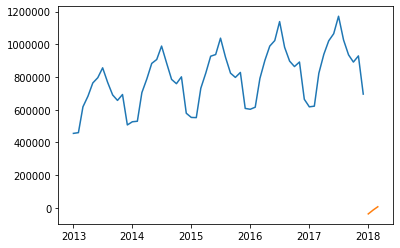

In [68]:
plt.plot(
        df_sales_pred['date'],
        df_sales_pred['sales'],
    )
plt.plot(
        df_sales_pred['date'],
        df_sales_pred['pred_value'],
    )

In [69]:
df_sales_pred

,date,pred_value,sales
0,2013-01-01,NaN,454904.0
1,2013-02-01,NaN,459417.0
2,2013-03-01,NaN,617382.0
3,2013-04-01,NaN,682274.0
4,2013-05-01,NaN,763242.0
5,2013-06-01,NaN,795597.0
6,2013-07-01,NaN,855922.0
7,2013-08-01,NaN,766761.0
8,2013-09-01,NaN,689907.0
9,2013-10-01,NaN,656587.0
